In [1]:
import sys
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch
from preprocess import process_eegs
from helper import reparameterization
from scipy.stats import ttest_ind
#from teja_vae_cpd import teja_vae_cpd
import mne
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import TensorFox as tfx
import torch
import torch.nn as nn

In [2]:
full_psds, _, _, _, _, grade, epi_dx, alz_dx, _, _, _, _, raw_eegs = process_eegs(return_raw= True)
an_eegs = raw_eegs[(epi_dx<0) & (alz_dx<0)]
pop_psds= full_psds[(epi_dx<0) & (alz_dx<0)]
psds_min = torch.min(pop_psds)
psds_max = torch.max(pop_psds)

trans_psds = (pop_psds - psds_min)/(psds_max - psds_min)

In [3]:
ch_names = ['fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 
            'fp2', 'f4', 'f8', 'c4', 't8', 'p4', 'p8', 'o2',
            'fz', 'cz', 'pz']
ch_names = [ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp') for ch_name in ch_names]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

def plot_factors(factors, d=3, factors_name=["Epochs", "Topomap", "Spectrum"]):

    rank = factors[0].shape[1]
    
    # sns.reset_orig()
    fig, all_axs = plt.subplots(rank, d, figsize=(12, int(rank * 2 + 1)))
    
    for ind, (factor, axs) in enumerate(zip(factors[:d], all_axs.T)):
        # axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            if ind == 0:
                sns.kdeplot(data=f, ax=ax)
            if ind == 1:
                mne.viz.plot_topomap(f, info, sensors=False, contours=0, cmap=cm.viridis, show=False, axes=ax)
            if ind == 2:
                sns.despine(top=True, ax=ax)
                ax.plot(f)
                ax.set_xlabel("Frequency (Hz)")
            all_axs[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    plt.show()

In [4]:
model = torch.load("../checkpoints/teja_vae_cp_epoch_85.pth")
#model = torch.load("../checkpoints/teja_vae_cp_supervised_original_rank_6.pth")
model.eval()
model.to("cuda:0")
trans_psds = trans_psds.to(torch.float32)
trans_psds = trans_psds.to("cuda:0")
epoch_components, _, _ = model.encoder(trans_psds)
epoch_components = epoch_components#.detach().cpu()
spatial_components = model.decoder.other_mus[0]#.detach().cpu()
frequency_components = model.decoder.other_mus[1]#.detach().cpu()

factors = [epoch_components, spatial_components, frequency_components]

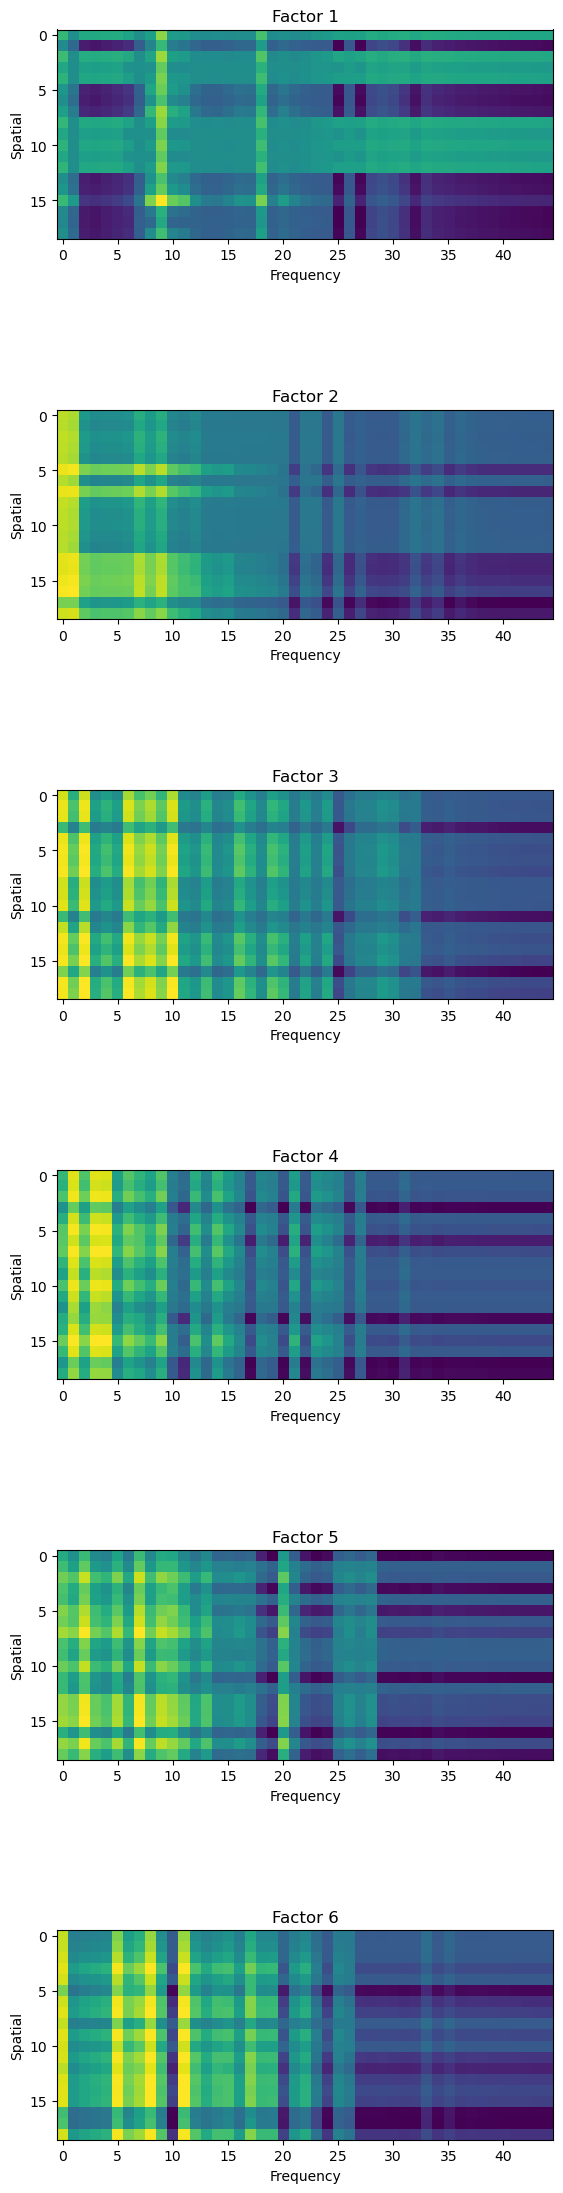

In [5]:
trans_psds = trans_psds[:100]
images = []
rank = epoch_components.shape[1]
num_dims = len(factors)
indices = model.decoder._create_indices(trans_psds.shape)

fig, ax = plt.subplots(6,1, figsize = (6.4,4.8*6))

for r in range(rank):
    Us = []
    for i in range(num_dims):
        Us.append((factors[i][indices[:,i]][:,r]).view(-1,1))

    #Concatenates tensors to form u vector from paper 
    U_vecs = torch.concat(Us, dim=1)

    #Pass u vector through the decoder layers to generate mean and log_var value for each "rank-1" tensor
    #Note: The original paper uses the tanh function for the hidden layer
    hidden = model.decoder.tanh(model.decoder.FC_input(U_vecs))


    #NOTE: use ReLU Activation
    elements_mean = model.decoder.sigmoid(model.decoder.FC_mean(hidden))

    elements_log_var =  model.decoder.FC_log_var(hidden)

    #Sample Elements
    elements = elements_mean #reparameterization(elements_mean, elements_log_var)
    psds = elements#1/rank *model.decoder.sigmoid(elements)
    psds = psds.view(trans_psds.shape)
    psds = torch.mean(psds, dim=0)
    ax[r].imshow(psds.cpu().detach().numpy())
    ax[r].set_title(f"Factor {r+1}")
    ax[r].set_ylabel("Spatial")
    ax[r].set_xlabel("Frequency")
plt.show()
    